# BCI Project

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import pywt
import pandas as pd
from PIL import Image, ImageDraw
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import (erosion, dilation, closing, opening, area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
from skimage.metrics import mean_squared_error as MSE, peak_signal_noise_ratio as PSNR, structural_similarity as SSIM

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Step wise

## Reading Image

255

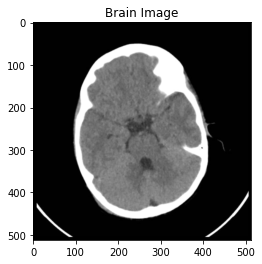

In [ ]:
img = imread(f'/content/gdrive/MyDrive/Projects/DWT-DCT-Watermark-Algorithm-main/images/brain.png')

fig, ax = plt.subplots(1,1)
ax.set_title("Brain Image")
ax.imshow(img, cmap='gray')
# plt.show()
img.max()

## Thresholding

Use OTSU to find appropriate threshold

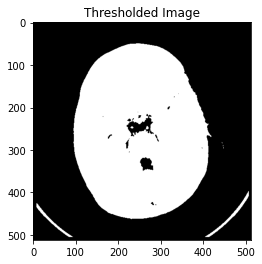

In [ ]:
threshold = threshold_otsu(img)
result = (img > threshold)
fig, ax = plt.subplots(1,1)
ax.set_title("Thresholded Image")
ax.imshow(result,cmap="gray")
plt.show()

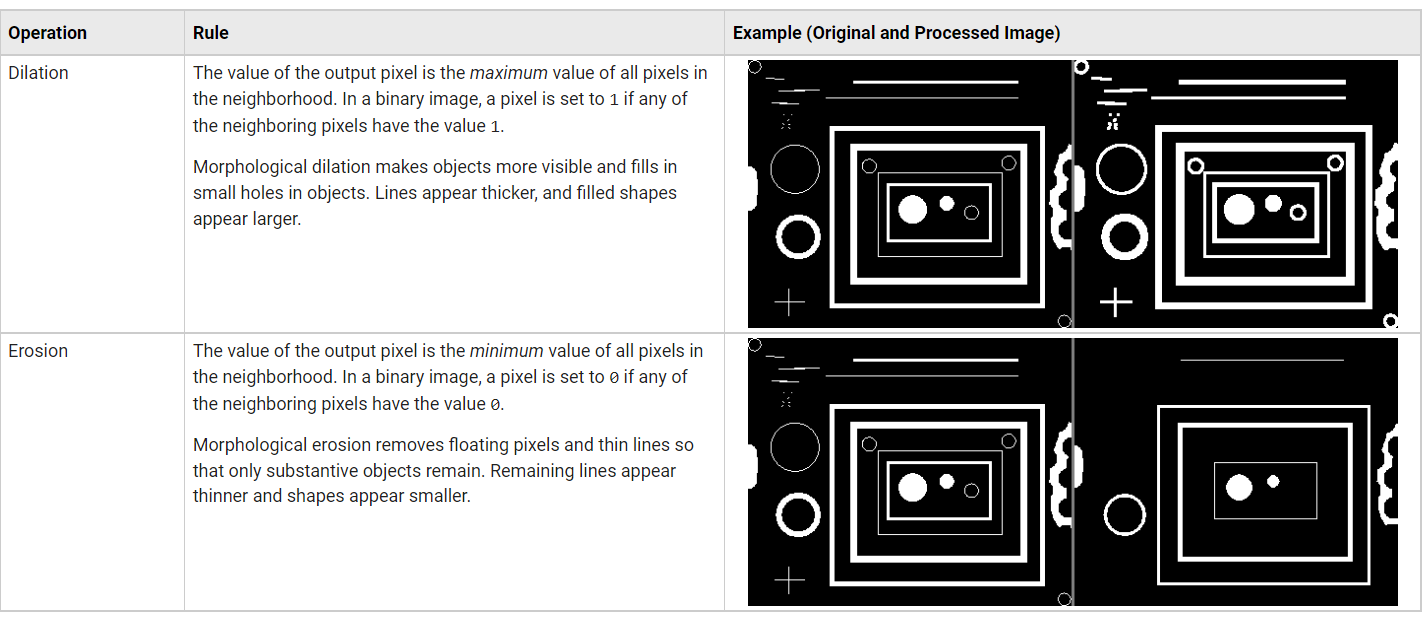

**Refrence on Morphological Operations**
1. https://towardsdatascience.com/understanding-morphological-image-processing-and-its-operations-7bcf1ed11756

> We will be using connected regions algorithm for extracting the ROI, for that we will have to cleanup the thresholded image. In the image below we are applying morphological operations such as sucessive `dilation` to close the pixels, `area_closing` to fill the holes (ventricles) in the brain and successive `erosion` to restore the original shape and `opening` to remove noise from the image.

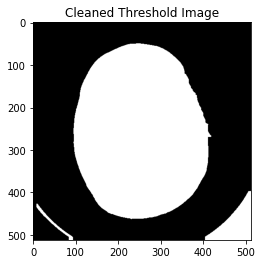

In [ ]:
# selection of window
sq = np.array([[1, 1, 1],
               [1, 1, 1],
               [1, 1, 1]])

# apply dilation
def multi_dil(img, num, elem = sq):
    for i in range(num):
        img = dilation(img, elem)
    return img

#applying erosion
def multi_ero(img, num, elem = sq):
    for i in range(num):
        img = erosion(img, elem)
    return img

# opening = first erosion and dilation
multi_dilated = multi_dil(result, 7)
area_closed = area_closing(multi_dilated, 50000)
multi_eroeded = multi_ero(area_closed, 7)
opened = opening(multi_eroeded)

fig, ax = plt.subplots(1,1)
ax.set_title("Cleaned Threshold Image")
ax.imshow(opened, cmap='gray')
plt.show()

## Extracting ROI Features

`label` feature is used to find some properties like area, perimeter, solidity, eccentricity, bounding box area and area ratio of the image.

In [ ]:
label_img = label(opened)
regions = regionprops(label_img)

prop = ['area','bbox_area', 'solidity', 'eccentricity','perimeter']

prop_table = pd.DataFrame(regionprops_table(label_img, result, properties=prop))

prop_table['area_ratio'] = prop_table['area'] / prop_table['bbox_area']

prop_table

,area,bbox_area,solidity,eccentricity,perimeter,area_ratio
0,103555,133812,0.989366,0.653620,1242.271211,0.773884
1,5985,12420,0.865510,0.838407,388.693434,0.481884
2,725,7396,0.583736,0.997798,257.404112,0.098026


## ROI Extraction

We select the region with the maximum area and use the bbox attribute the pixel locations of the bounding box of that region and extract that region from the original image

Ref : https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html

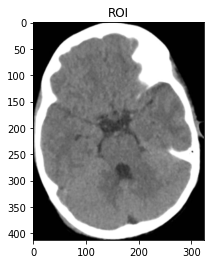

In [ ]:
# The idxmax() method returns a Series with the index of the
#  maximum value for each column.
index = prop_table['area'].idxmax()

# Returns an approximate bounding box for item, 
# a tuple of four integers: the pixel coordinates of minimum x, minimum y, maximum x, maximum y, in this order.
box = regions[index].bbox

ROI = img[box[0]:box[2], box[1]:box[3]]

fig, ax = plt.subplots(1, 1)
ax.set_title("ROI")
ax.imshow(ROI, cmap="gray")
plt.show()

## ROI Watermark Generation

Extracted features from ROI will be embedded in the image.
The size will be $\frac{1}{4}$ of ROI as embedding will be done in `LL2` region of Discrete Wavelet Transform.<br>

**Multiline Draw** : https://www.geeksforgeeks.org/python-pil-imagedraw-draw-multiline_text/

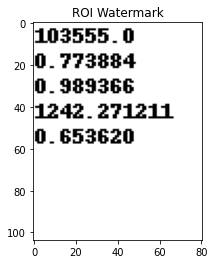

1.0

In [ ]:
area = prop_table.iloc[index].area
area_ratio = prop_table.iloc[index].area_ratio
solidity = prop_table.iloc[index].solidity
perimeter = prop_table.iloc[index].perimeter
eccentricity = prop_table.iloc[index].eccentricity

# convert all attributes in a string
area_ratio_str = "{:.6f}".format(area_ratio)
solidity_str = "{:.6f}".format(solidity)
perimeter_str = "{:.6f}".format(perimeter)
eccentricity_str = "{:.6f}".format(eccentricity)


height, width = ROI.shape

watermark_text = f"{area}\n{area_ratio_str}\n{solidity_str}\n{perimeter_str}\n{eccentricity_str}"

ROI_watermark = Image.new("RGB", (math.ceil(width/4), math.ceil(height/4)), color=(255, 255, 255))
ROI_watermark_draw = ImageDraw.Draw(ROI_watermark)

ROI_watermark_draw.multiline_text((1, 1), watermark_text, 
                                  spacing=1,fill=(0,0,0))

ROI_watermark_array = np.asarray(ROI_watermark)
ROI_watermark = rgb2gray(ROI_watermark_array)

fig, ax = plt.subplots(1, 1)
ax.set_title('ROI Watermark')
ax.imshow(ROI_watermark, cmap='gray')
plt.show()
ROI_watermark.max()

## ROI Watermark Encryption

We will be using Logistic Map encryption for encrypting our ROI watermark. The logistic map uses a pseudo random sequence generated using the following formula:
<html><body><p>X<sub>n+1</sub> = μX<sub>n</sub>(1 - X<sub>n</sub>)</p></body></html>
<html><body><p>We will be using the value of X<sub>n</sub> as 0.9 and μ as 3.95</p></body></html>

$\mu$ will be 3.95 as after $\mu=3.8$ logistic map starts showing chaotic behavior

1. Image Encryption : https://www.youtube.com/watch?v=DOwy0SuGD7Q&ab_channel=PotcharapholChat-anan

2. Logistic Map :
    - The Logistic Map: Attractors, Bifurcation, and Chaos : https://youtu.be/_z-e7N99-rI
    - https://www.youtube.com/watch?v=ovJcsL7vyrk

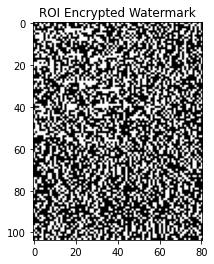

In [ ]:
def logistic_encryption(watermark):
    row, col = watermark.shape
    N = row * col
    x = 0.9 + np.zeros(N)
    r = 3.95
    for n in range(N-1):
        x[n+1] = r * x[n] * (1 - x[n])
    x = x.reshape(row, col)
    bool_x = np.around(x).astype('int')
    watermark = watermark.astype('int')
    encrypted_watermark = np.bitwise_xor(watermark, bool_x).astype('float')
    return encrypted_watermark, bool_x

ROI_encrypted_watermark, bool_x = logistic_encryption(ROI_watermark)
fig, ax = plt.subplots(1,1)
ax.set_title("ROI Encrypted Watermark")
ax.imshow(ROI_encrypted_watermark, cmap="gray")
plt.show()

## ROI Watermark Emedding

Perform Discrete Wavelet Transform with **haar** wavelet.

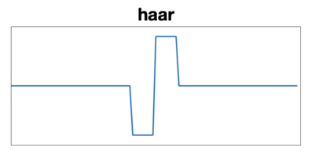

In [ ]:
model = "haar"
k = 8
def process_coefficients(imArray, model, level):
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    coeffs_H=(coeffs)
    return coeffs_H

def quantization_step(LH2, HL2, HH2, k):
    LH2 = np.absolute(LH2).sum()
    HL2 = np.absolute(HL2).sum()
    HH2 = np.absolute(HH2).sum()
    return k * round(math.log((LH2 + HL2 + HH2) / 2))

def DWT(ROI, model, level, k):
    coeffs_image = process_coefficients(ROI, model, level=level)
    LL2 , (LH2, HL2, HH2), (LH1, HL1, HH1) = coeffs_image
    Q = quantization_step(LH2, HL2, HH2, k)
    Xq = LL2 / Q
    return Xq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q

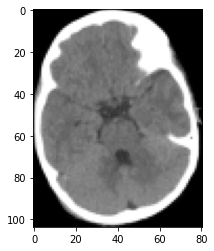

In [ ]:
Xq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q = DWT(ROI, model, 2, k)
plt.imshow(Xq,cmap="gray")
plt.show()

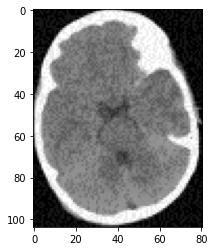

In [ ]:
Xq_copy = Xq.copy()
row, col = Xq_copy.shape
for i in range(row):
    for j in range(col):
        if(round(Xq[i,j]%2) == ROI_encrypted_watermark[i,j]):
            Xq_copy[i,j] = Xq[i,j] * Q
        else:
            Xq_copy[i,j] = (Xq[i,j] * Q) + Q

plt.imshow(Xq_copy, cmap="gray")
plt.show()

## Reconstruction

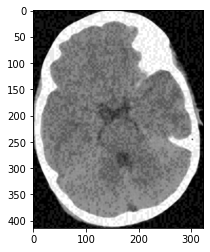

In [ ]:
# Reconstruction of the image
coeffs = [Xq_copy, (LH2, HL2, HH2), (LH1, HL1, HH1)]
image = pywt.waverec2(coeffs, model)
image = np.absolute(image)
plt.imshow(image, cmap='gray')
plt.show()

## ROI Watermark Extraction

To extract the watermnark we take the XOR of the Reconstructed image and the `boolean_x` (the one which we had found while implementing logistic map)

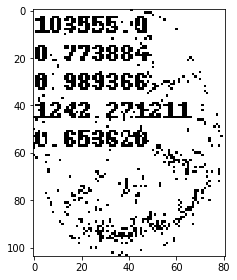

In [ ]:
def extract_ROI_watermark(image,boolean_x):
    Zq, (LH2, HL2, HH2), (LH1, HL1, HH1), Q = DWT(image, model, 2, 8)
    Zq = np.round(Zq)
    Wsroi = Zq%2
    Wroi_salt = Wsroi.copy().astype("int")^boolean_x
    return Wroi_salt.astype("float")

extracted_ROI_watermark = extract_ROI_watermark(image,bool_x)
imshow(extracted_ROI_watermark)

# Attacks

## Salt and Pepper Noise

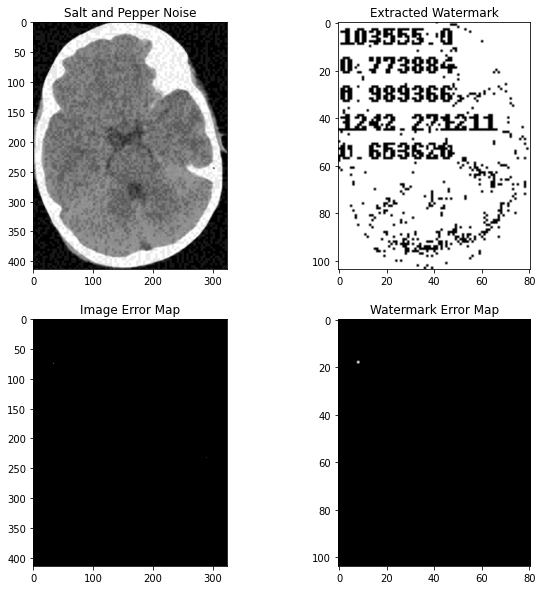

In [ ]:
def add_salt_pepper_noise(X_img):
    X_img_copy = X_img.copy()
    row, col = X_img_copy.shape
    salt_vs_pepper = 0.5
    amount = 0.01
    num_salt = np.ceil(amount * X_img_copy.size * salt_vs_pepper * 0.0001)
    num_pepper = np.ceil(amount * X_img_copy.size * (1.0 - salt_vs_pepper) * 0.0001)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
    X_img_copy[coords[0], coords[1]] = 1
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
    X_img_copy[coords[0], coords[1]] = 0
    return X_img_copy

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

salt_pepper_noise_imgs = add_salt_pepper_noise(image)
axs[0, 0].set_title("Salt and Pepper Noise")
axs[0, 0].imshow(salt_pepper_noise_imgs,cmap="gray")

extracted_watermark = extract_ROI_watermark(salt_pepper_noise_imgs, bool_x)
axs[0, 1].set_title("Extracted Watermark")
axs[0 ,1].imshow(extracted_watermark,cmap="gray")

image_error_map = salt_pepper_noise_imgs.astype("int") ^ image.astype("int")
axs[1, 0].set_title("Image Error Map")
axs[1, 0].imshow(image_error_map,cmap="gray")

watermark_error_map = extracted_ROI_watermark.astype("int") ^ extracted_watermark.astype("int")
axs[1, 1].set_title("Watermark Error Map")
axs[1, 1].imshow(watermark_error_map,cmap="gray")
plt.show()

## Gaussian Noise

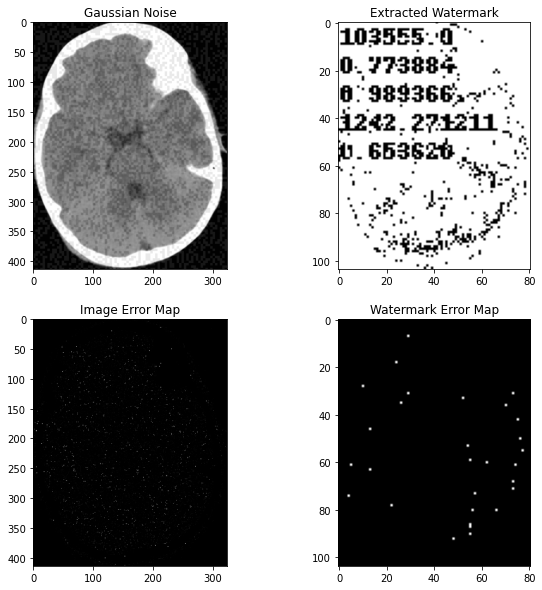

In [ ]:
def add_gaussian_noise(image):
    return np.random.normal(0,0.1**0.5,image.shape) + image

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
gaussian_noise_img = add_gaussian_noise(image)
axs[0, 0].set_title("Gaussian Noise")
axs[0, 0].imshow(gaussian_noise_img,cmap="gray")

extracted_watermark = extract_ROI_watermark(gaussian_noise_img, bool_x)
axs[0, 1].set_title("Extracted Watermark")
axs[0, 1].imshow(extracted_watermark,cmap="gray")

image_error_map = gaussian_noise_img.astype("int") ^ image.astype("int")
axs[1, 0].set_title("Image Error Map")
axs[1, 0].imshow(image_error_map,cmap="gray")

watermark_error_map = extracted_ROI_watermark.astype("int") ^ extracted_watermark.astype("int")
axs[1, 1].set_title("Watermark Error Map")
axs[1, 1].imshow(watermark_error_map,cmap="gray")

plt.show()

- Now perform the attack on the image and then extract watermarks from the image.
- Then check various errors like RMSE, MSE, and analyze the result

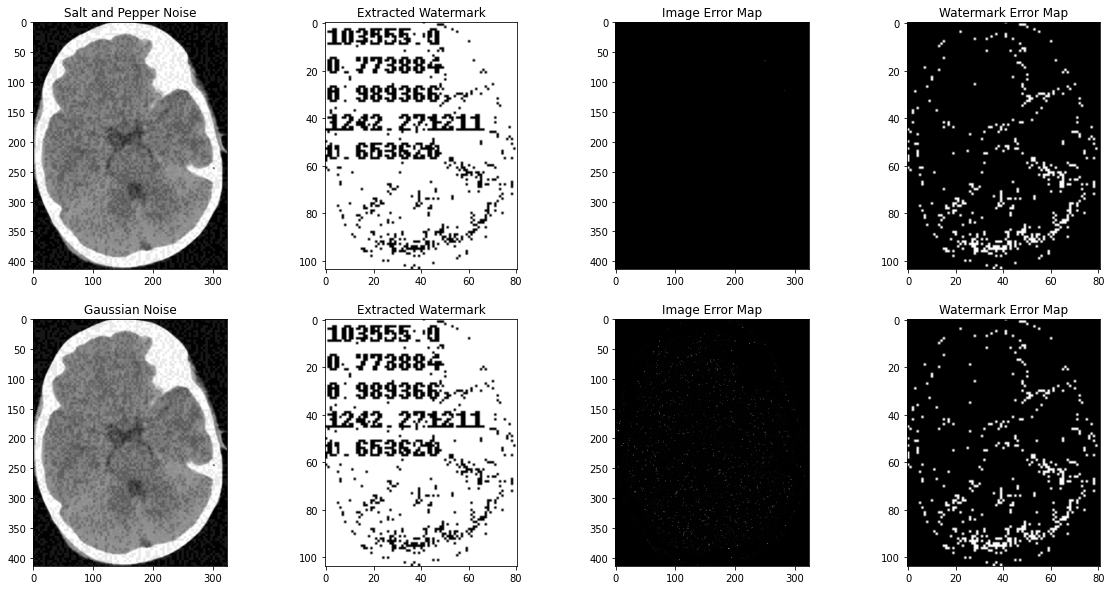

In [ ]:
attack_dict = {
    "Salt and Pepper Noise" : add_salt_pepper_noise,
    "Gaussian Noise" : add_gaussian_noise,
}
fig, axs = plt.subplots(len(attack_dict), 4, figsize=(20, 5*len(attack_dict)))
attacks_df = pd.DataFrame(columns = ['Attack', 'MSE', 'PSNR','SSIM'])

def apply_attacks(image, watermark, watermark_extraction_func, attack_dict, df):
    attacks = list(attack_dict.items())
    for i in range(len(attacks)):
        modified_image = attacks[i][1](image)
        axs[i,0].set_title(f"{attacks[i][0]}")
        axs[i,0].imshow(modified_image,cmap="gray")
        
        extracted_watermark = watermark_extraction_func(modified_image,bool_x)
        axs[i,1].set_title("Extracted Watermark")
        axs[i,1].imshow(extracted_watermark,cmap="gray")
        
        image_error_map = image.copy().astype("int")^modified_image.copy().astype("int")
        axs[i,2].set_title("Image Error Map")
        axs[i,2].imshow(image_error_map,cmap="gray")
        
        watermark_error_map = watermark.copy().astype("int") ^ extracted_watermark.copy().astype("int")
        axs[i,3].set_title("Watermark Error Map")
        axs[i,3].imshow(watermark_error_map,cmap="gray")
        mse = MSE(watermark, extracted_watermark)
        psnr = PSNR(watermark, extracted_watermark)
        ssim = SSIM(watermark, extracted_watermark)
        df.loc[i] = [attacks[i][0], mse, psnr, ssim]
    return df
        
attacks_df = apply_attacks(image,ROI_watermark, extract_ROI_watermark, attack_dict, attacks_df)

Print the data frame of various errors after the attack

In [ ]:
attacks_df

,Attack,MSE,PSNR,SSIM
0,Salt and Pepper Noise,0.056387,12.488247,0.545563
1,Gaussian Noise,0.057930,12.370985,0.530126


In [ ]:
Objectives :
1. PSNR >= 50
Embedding watermark and logo simultaneously
use various hybrid techniques(DWT, etc) along with encryption

2. Embedd watermark and logo (apply different encryptin algo like AES, DES) and then check PSNR

3. Extract info after performing various attacks (both images should be simillar)
NC and Bit error rate value should be close to 1.

4. Apply machine Learning for embedding watermark.